## Visualizing the threshold of each layers

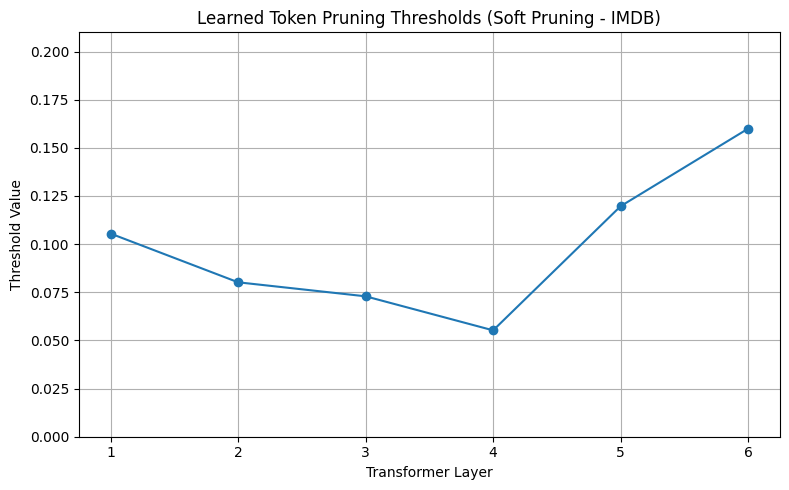

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Threshold values for each layer after soft pruning
# threshold values are from file "model_pipeline_imdb.ipynb"
thresholds = np.array([0.10545765, 0.08017303, 0.07289841, 0.05522738, 0.11968768, 0.15995482])

# Create layer indices
layers = np.arange(1, len(thresholds) + 1)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(layers, thresholds, marker='o')
plt.title("Learned Token Pruning Thresholds (Soft Pruning - IMDB)")
plt.xlabel("Transformer Layer")
plt.ylabel("Threshold Value")
plt.grid(True)
plt.xticks(layers)
plt.ylim(0, max(thresholds) + 0.05)
plt.tight_layout()
plt.show()

## Cleaning the remaining tokens by removing stopwords and meaningless tokens

In [2]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
import nltk

# Make sure you have stopwords downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load your CSV
df = pd.read_csv('imdb_predictions_with_pruned.csv')

# Function to clean a sentence
def clean_text(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(rf"[{re.escape(string.punctuation)}0-9]", " ", text)
    # Tokenize and filter
    tokens = text.split()
    filtered_tokens = [
        token for token in tokens
        if token not in stop_words and len(token) > 1 and token.isalpha()
    ]
    return " ".join(filtered_tokens)

# Apply cleaning
df['cleaned_remaining_sentence'] = df['remaining_sentence'].apply(clean_text)

# Select only required columns
cleaned_df = df[['input_sentence', 'cleaned_remaining_sentence', 'predicted_label', 'true_label']]

# Save cleaned file
cleaned_df.to_csv('cleaned_imdb_pruned.csv', index=False)

print("✅ Cleaned file saved as 'cleaned_imdb_pruned.csv'")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Cleaned file saved as 'cleaned_imdb_pruned.csv'


## 1. Frequency analysis 

Analyze the frequency of most repeated words among retained tokens

### Correct Predictions

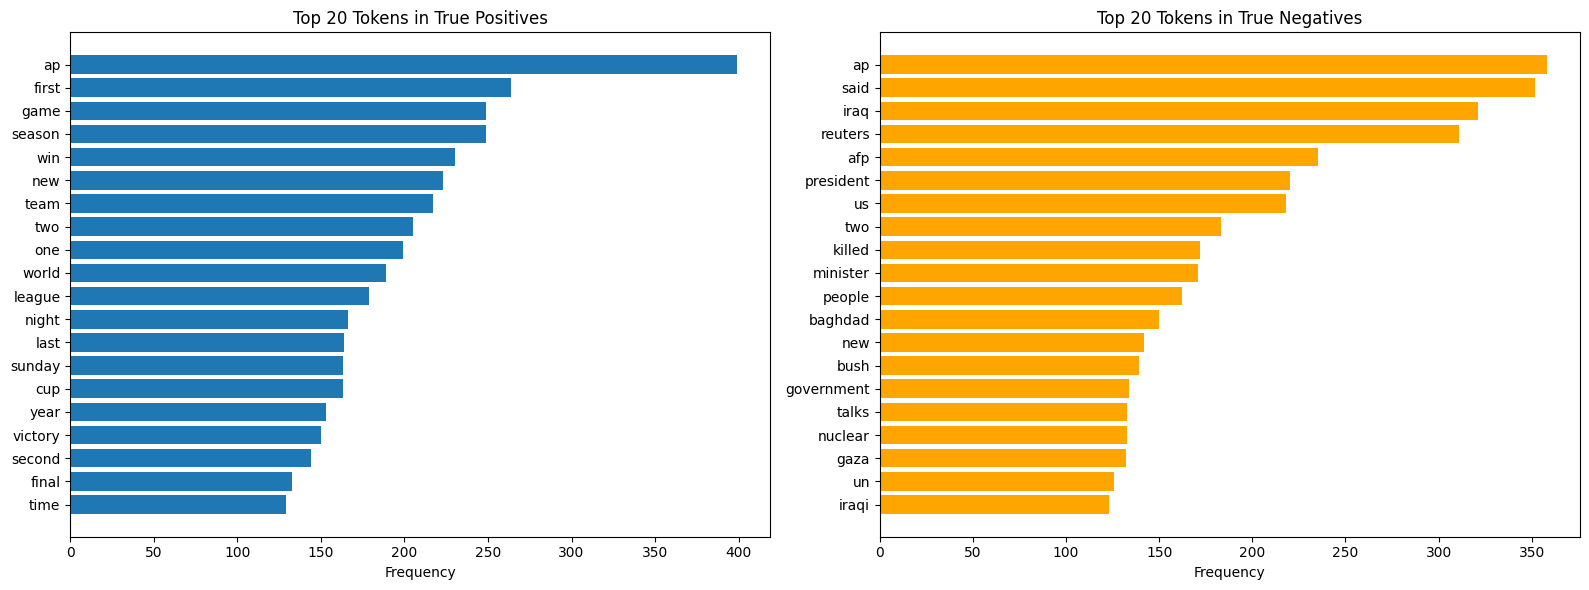

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your CSV file
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Optional: clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Filter for True Positives and False Positives
true_positives = df[(df['true_label'] == 1) & (df['predicted_label'] == 1)]
true_negatives = df[(df['true_label'] == 0) & (df['predicted_label'] == 0)]

def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
tp_top_tokens = get_top_tokens(true_positives)
tn_top_tokens = get_top_tokens(true_negatives)

# Save token counts to CSV
os.makedirs("results_imdb/token_counts", exist_ok=True)
pd.DataFrame(tp_top_tokens, columns=["token", "frequency"]).to_csv("results_imdb/token_counts/true_positives_top20.csv", index=False)
pd.DataFrame(tn_top_tokens, columns=["token", "frequency"]).to_csv("results_imdb/token_counts/true_negatives_top20.csv", index=False)

# Unpack for plotting
tp_tokens, tp_counts = zip(*tp_top_tokens) if tp_top_tokens else ([], [])
tn_tokens, tn_counts = zip(*tn_top_tokens) if tn_top_tokens else ([], [])

# Plotting (remove sharey=True to treat Y-axes independently)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True Positives plot
axes[0].barh(range(len(tp_tokens)), tp_counts, align='center')
axes[0].set_yticks(range(len(tp_tokens)))
axes[0].set_yticklabels(tp_tokens)
axes[0].set_title("Top 20 Tokens in True Positives")
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency")

# False Positives plot
axes[1].barh(range(len(tn_tokens)), tn_counts, color='orange', align='center')
axes[1].set_yticks(range(len(tn_tokens)))
axes[1].set_yticklabels(tn_tokens)
axes[1].set_title("Top 20 Tokens in True Negatives")
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_imdb/plots", exist_ok=True)
plt.savefig("results_imdb/plots/top20_tokens_TP_FP.png")
plt.show()



### Incorrect predictions

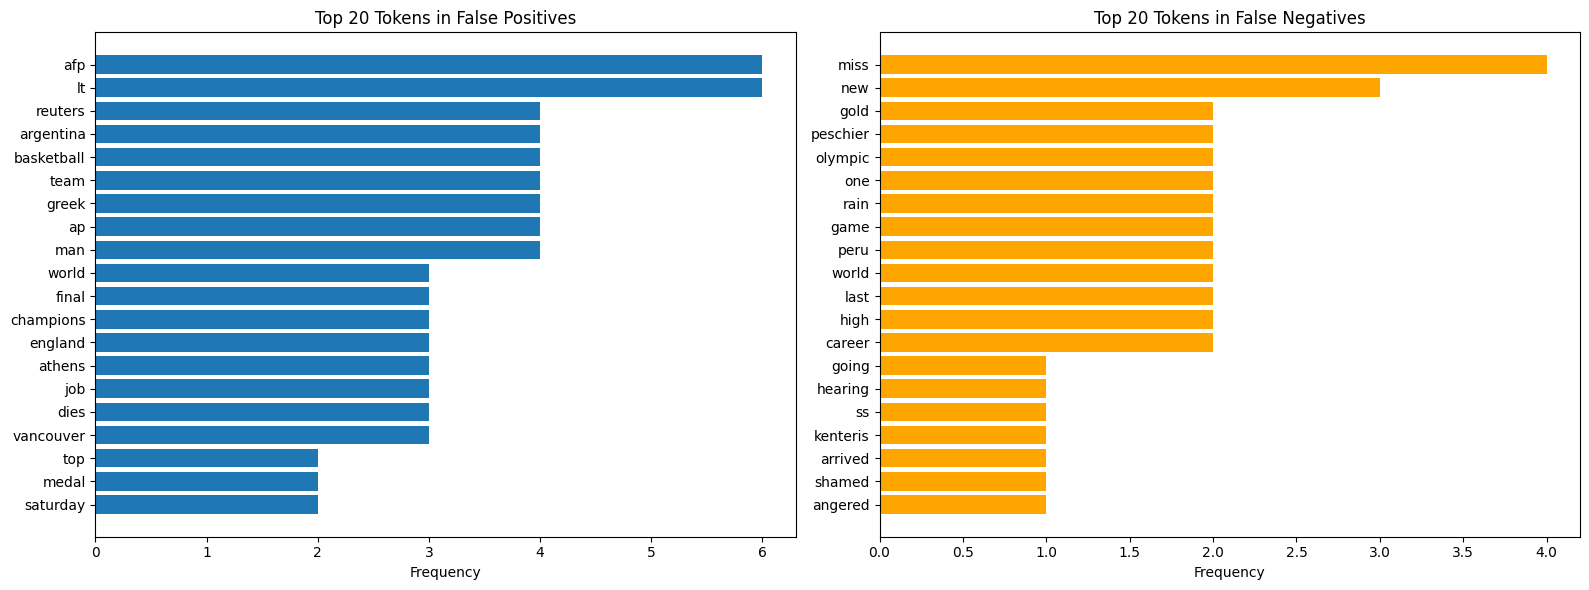

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load your CSV file
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Optional: clean NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Filter for True Positives and False Positives
false_positives = df[(df['true_label'] == 0) & (df['predicted_label'] == 1)]
false_negatives = df[(df['true_label'] == 1) & (df['predicted_label'] == 0)]

def get_top_tokens(dataframe, column='cleaned_remaining_sentence', top_k=20):
    all_tokens = []
    for sent in dataframe[column]:
        tokens = sent.lower().strip().split()
        all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    return counter.most_common(top_k)

# Get top tokens
fp_top_tokens = get_top_tokens(false_positives)
fn_top_tokens = get_top_tokens(false_negatives)

# Save token counts to CSV
os.makedirs("results_imdb/token_counts", exist_ok=True)
pd.DataFrame(fp_top_tokens, columns=["token", "frequency"]).to_csv("results_imdb/token_counts/false_positives_top20.csv", index=False)
pd.DataFrame(fn_top_tokens, columns=["token", "frequency"]).to_csv("results_imdb/token_counts/false_negatives_top20.csv", index=False)

# Unpack for plotting
fp_tokens, fp_counts = zip(*fp_top_tokens) if fp_top_tokens else ([], [])
fn_tokens, fn_counts = zip(*fn_top_tokens) if fn_top_tokens else ([], [])

# Plotting (remove sharey=True to treat Y-axes independently)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True Positives plot
axes[0].barh(range(len(fp_tokens)), fp_counts, align='center')
axes[0].set_yticks(range(len(fp_tokens)))
axes[0].set_yticklabels(fp_tokens)
axes[0].set_title("Top 20 Tokens in False Positives")
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency")

# False Positives plot
axes[1].barh(range(len(fn_tokens)), fn_counts, color='orange', align='center')
axes[1].set_yticks(range(len(fn_tokens)))
axes[1].set_yticklabels(fn_tokens)
axes[1].set_title("Top 20 Tokens in False Negatives")
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency")

plt.tight_layout()
os.makedirs("results_imdb/plots", exist_ok=True)
plt.savefig("results_imdb/plots/top20_tokens_fp_FP.png")
plt.show()

## 2. Word Cloud

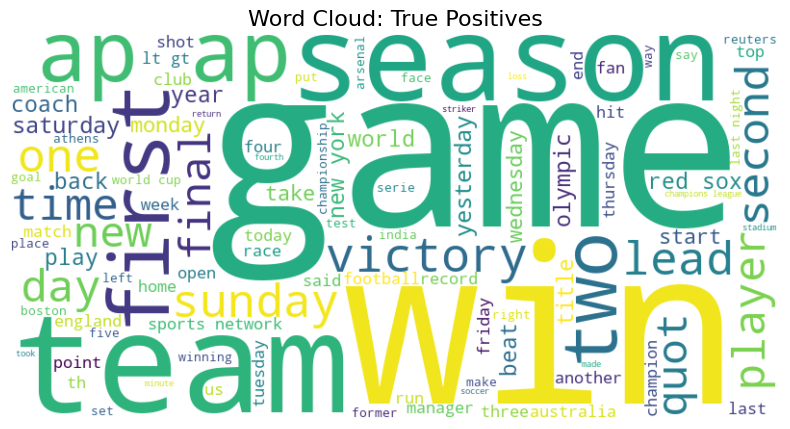

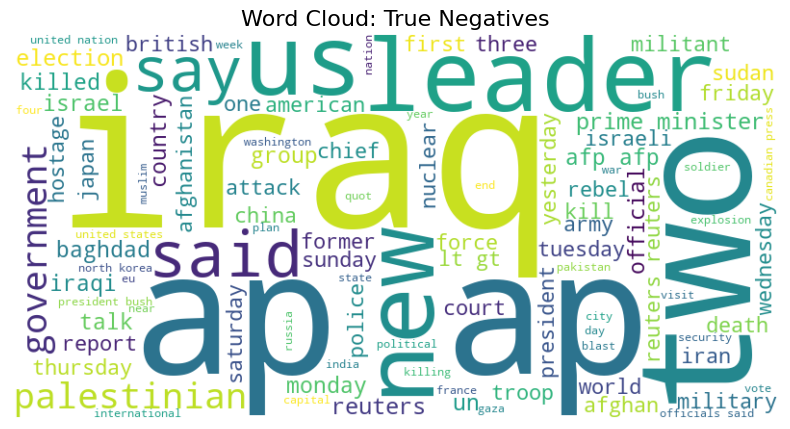

In [46]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Load the cleaned CSV
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Drop NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Filter for True Positives and True Negatives
true_positives = df[(df['true_label'] == 1) & (df['predicted_label'] == 1)]
true_negatives = df[(df['true_label'] == 0) & (df['predicted_label'] == 0)]

# Function to generate and save a word cloud
def generate_wordcloud(text_series, title, filename):
    text = " ".join(text_series.astype(str))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    os.makedirs("results_imdb/wordclouds", exist_ok=True)
    plt.savefig(f"results_imdb/wordclouds/{filename}", bbox_inches='tight')
    plt.show()

# Generate word clouds
generate_wordcloud(true_positives['cleaned_remaining_sentence'], "Word Cloud: True Positives", "true_positives_wordcloud.png")
generate_wordcloud(true_negatives['cleaned_remaining_sentence'], "Word Cloud: True Negatives", "true_negatives_wordcloud.png")

### Incorrect Predictions

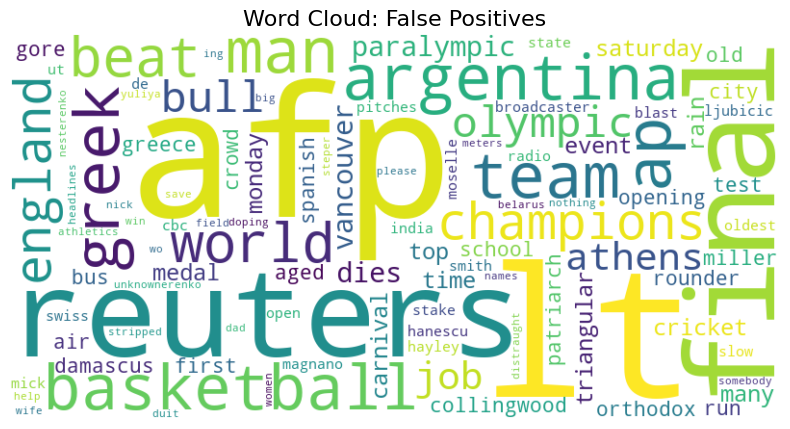

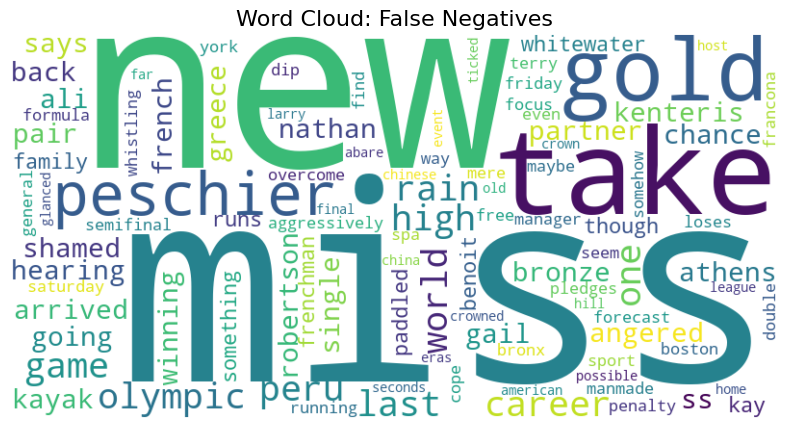

In [47]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Load the cleaned CSV
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Drop NaNs
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Filter for True Positives and True Negatives
false_positives = df[(df['true_label'] == 0) & (df['predicted_label'] == 1)]
false_negatives = df[(df['true_label'] == 1) & (df['predicted_label'] == 0)]

# Function to generate and save a word cloud
def generate_wordcloud(text_series, title, filename):
    text = " ".join(text_series.astype(str))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    os.makedirs("results_imdb/wordclouds", exist_ok=True)
    plt.savefig(f"results_imdb/wordclouds/{filename}", bbox_inches='tight')
    plt.show()

# Generate word clouds
generate_wordcloud(false_positives['cleaned_remaining_sentence'], "Word Cloud: False Positives", "false_positives_wordcloud.png")
generate_wordcloud(false_negatives['cleaned_remaining_sentence'], "Word Cloud: False Negatives", "false_negatives_wordcloud.png")

## 3. POS TAG Frequency

In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/christomathew/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### generate the pos tag file

## Plotting the top POS Tags

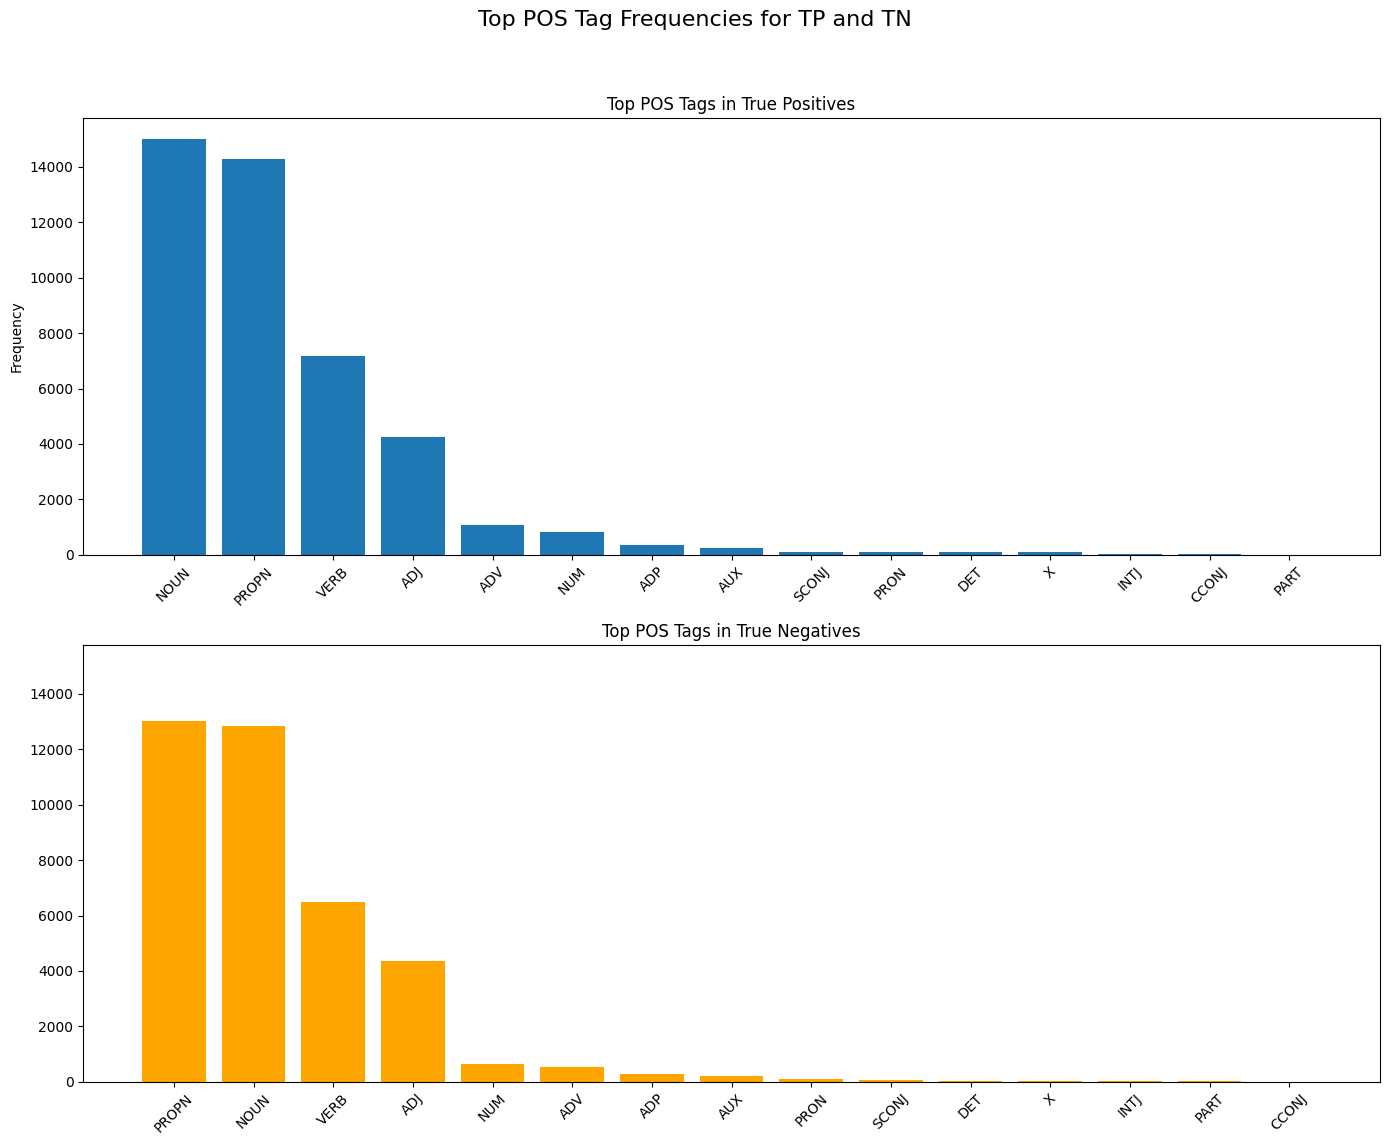

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the updated DataFrame
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # Make sure this model is installed

# Load your cleaned CSV
df = pd.read_csv('cleaned_imdb_pruned.csv')

# Drop NaNs if any
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Function to perform POS tagging using spaCy
def pos_tag_spacy(sentence):
    doc = nlp(sentence)
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])

# Apply POS tagging
df['pos_tags'] = df['cleaned_remaining_sentence'].apply(pos_tag_spacy)

# Save the updated DataFrame
df.to_csv('cleaned_imdb_pruned.csv', index=False)

# Drop rows with missing values in 'pos_tags'
df = df.dropna(subset=['pos_tags'])

# Filter TP and TN
tp_df = df[(df['true_label'] == 1) & (df['predicted_label'] == 1)]
tn_df = df[(df['true_label'] == 0) & (df['predicted_label'] == 0)]

# Helper function to extract POS tags
def get_pos_frequencies(pos_series, top_k=15):
    pos_list = []
    for tag_str in pos_series:
        pos_tags = [pair.rsplit('/', 1)[-1] for pair in tag_str.split()]
        pos_list.extend(pos_tags)
    return Counter(pos_list).most_common(top_k)

# Get frequencies
tp_pos_freq = get_pos_frequencies(tp_df['pos_tags'])
tn_pos_freq = get_pos_frequencies(tn_df['pos_tags'])

# Unzip for plotting
tp_tags, tp_counts = zip(*tp_pos_freq)
tn_tags, tn_counts = zip(*tn_pos_freq)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharey=True)

axes[0].bar(tp_tags, tp_counts)
axes[0].set_title("Top POS Tags in True Positives")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(tn_tags, tn_counts, color='orange')
axes[1].set_title("Top POS Tags in True Negatives")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Top POS Tag Frequencies for TP and TN", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
os.makedirs("results_imdb/post_tag", exist_ok=True)
plt.savefig(f"results_imdb/post_tag/tp_and_tn", bbox_inches='tight')

plt.show()

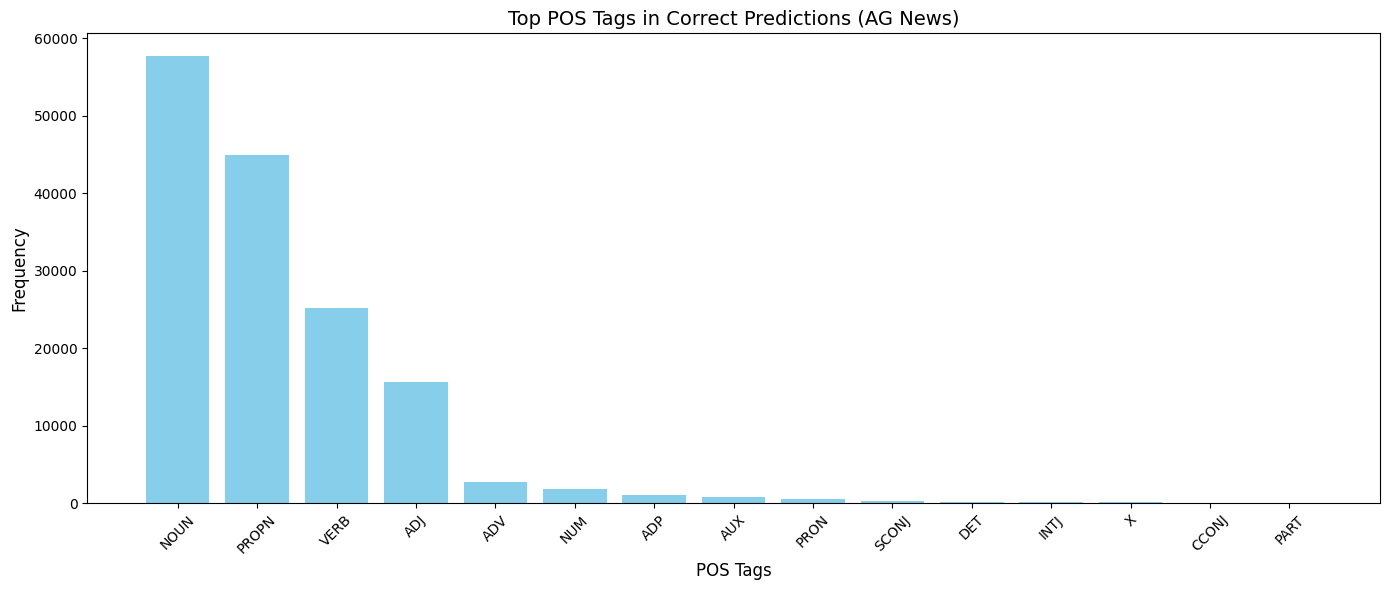

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load AG News dataset
df = pd.read_csv('cleaned_agnews_pruned.csv')

# Drop rows missing necessary columns
df = df.dropna(subset=['cleaned_remaining_sentence'])

# Add POS tags if not already done
def pos_tag_spacy(sentence):
    doc = nlp(sentence)
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])

if 'pos_tags' not in df.columns:
    df['pos_tags'] = df['cleaned_remaining_sentence'].apply(pos_tag_spacy)
    df.to_csv('cleaned_agnews_pruned.csv', index=False)

# Drop NaNs in pos_tags
df = df.dropna(subset=['pos_tags'])

# Keep only correct predictions (true_label == predicted_label)
correct_df = df[df['true_label'] == df['predicted_label']]

# Helper to extract POS tag frequencies
def get_pos_frequencies(pos_series, top_k=15):
    pos_list = []
    for tag_str in pos_series:
        pos_tags = [pair.rsplit('/', 1)[-1] for pair in tag_str.split()]
        pos_list.extend(pos_tags)
    return Counter(pos_list).most_common(top_k)

# Get POS frequencies
true_freq = get_pos_frequencies(correct_df['pos_tags'])

# Prepare for plotting
true_tags, true_counts = zip(*true_freq)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.bar(true_tags, true_counts, color='skyblue')
ax.set_title("Top POS Tags in Correct Predictions (AG News)", fontsize=14)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlabel("POS Tags", fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"results_imdb/post_tag/correct_predictions", bbox_inches='tight')

plt.show()


## T-SNE  Clustering

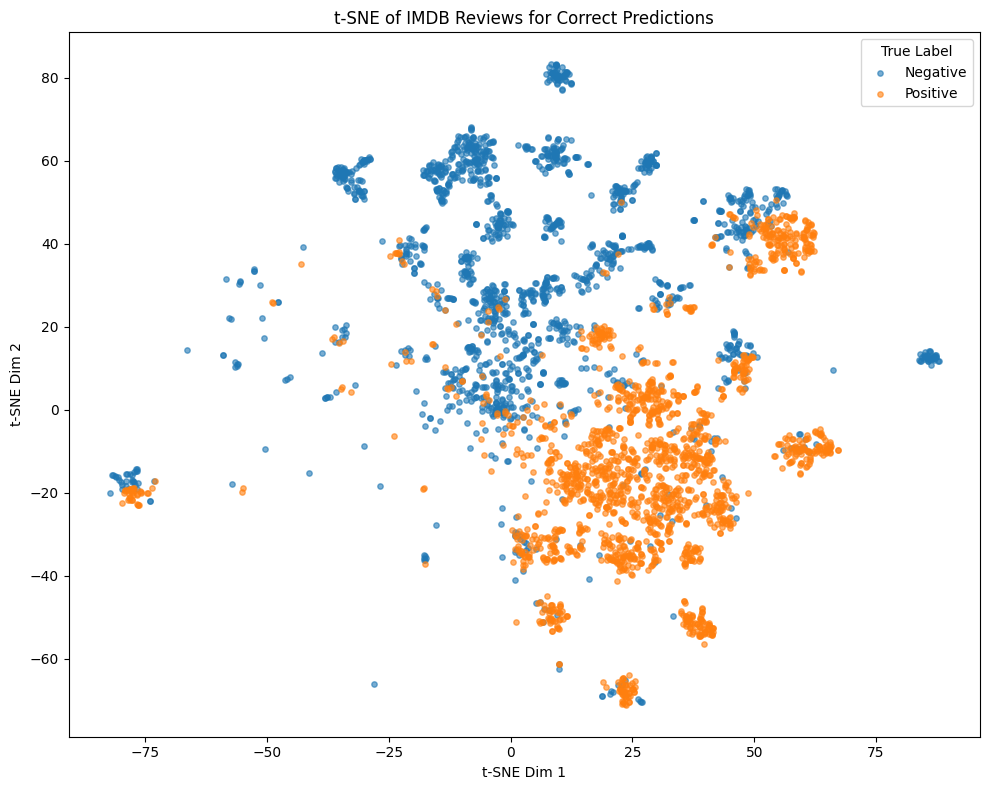

In [54]:
### t-sne for correct predictions
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load your stopword‐filtered IMDB pruning file
df = pd.read_csv('cleaned_imdb_pruned.csv')

df = df[df['predicted_label'] == df['true_label']]
# 2. Parse the retained‐tokens column into real Python lists
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()

# 3. Build a "document" string of retained tokens for each review
df['doc_str'] = df['retained_list'].apply(lambda toks: ' '.join(toks))

# (Optional) subsample to speed up t-SNE if you have many examples
# df = df.sample(n=2000, random_state=42)

# 4. Vectorize with TF–IDF (limit to top 5,000 features)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['doc_str'])

# 5. (Optional) Pre‐reduce dimensionality with SVD to stabilize t-SNE
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# 6. Compute 2D t-SNE embeddings
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

# 7. Plot, coloring by true sentiment label
label_names = {0: "Negative", 1: "Positive"}
plt.figure(figsize=(10, 8))
for lbl, name in label_names.items():
    idx = df['true_label'] == lbl
    plt.scatter(
        X_embedded[idx, 0],
        X_embedded[idx, 1],
        s=15,
        alpha=0.6,
        label=name
    )

plt.legend(title="True Label")
plt.title("t-SNE of IMDB Reviews for Correct Predictions")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
os.makedirs("results_imdb/tsne", exist_ok=True)
plt.savefig(f"results_imdb/tsne/correct_predictions", bbox_inches='tight')

plt.show()

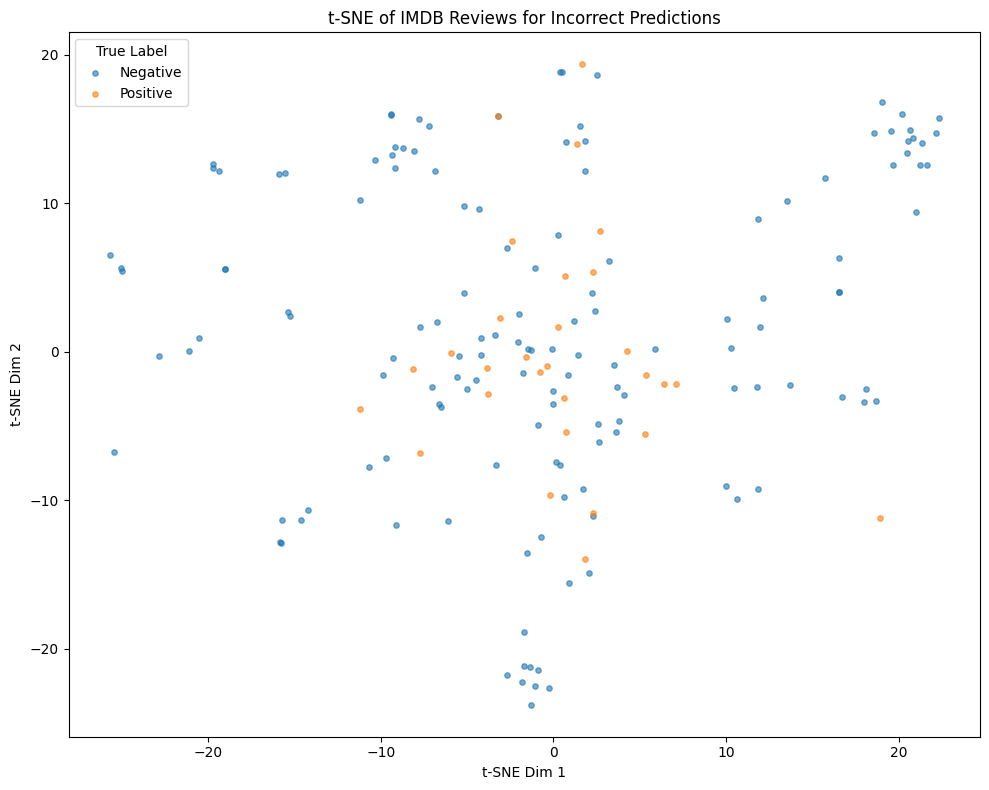

In [53]:
### t-sne for incorrect predictions
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load your stopword‐filtered IMDB pruning file
df = pd.read_csv('cleaned_imdb_pruned.csv')

df = df[df['predicted_label'] != df['true_label']]
# 2. Parse the retained‐tokens column into real Python lists
df['retained_list'] = df['cleaned_remaining_sentence'].str.split()

# 3. Build a "document" string of retained tokens for each review
df['doc_str'] = df['retained_list'].apply(lambda toks: ' '.join(toks))

# (Optional) subsample to speed up t-SNE if you have many examples
# df = df.sample(n=2000, random_state=42)

# 4. Vectorize with TF–IDF (limit to top 5,000 features)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['doc_str'])

# 5. (Optional) Pre‐reduce dimensionality with SVD to stabilize t-SNE
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# 6. Compute 2D t-SNE embeddings
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_embedded = tsne.fit_transform(X_reduced)

# 7. Plot, coloring by true sentiment label
label_names = {0: "Negative", 1: "Positive"}
plt.figure(figsize=(10, 8))
for lbl, name in label_names.items():
    idx = df['true_label'] == lbl
    plt.scatter(
        X_embedded[idx, 0],
        X_embedded[idx, 1],
        s=15,
        alpha=0.6,
        label=name
    )

plt.legend(title="True Label")
plt.title("t-SNE of IMDB Reviews for Incorrect Predictions")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
os.makedirs("results_imdb/tsne", exist_ok=True)

plt.tight_layout()
plt.savefig(f"results_imdb/tsne/incorrect_predictions", bbox_inches='tight')
plt.show()